In [1]:
import os
os.chdir('drive/My Drive/MLProject_20202')

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import format_length, get_lstm_vectors, get_doc2vec_vectors, plot_loss,\
                    plot_cm, plot_metrics, plot_prc, plot_roc

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
df_cat = pd.read_csv('Data/data_all_categorical.csv', encoding='utf-8')
y = df_cat.fraudulent

In [5]:
# initial bias
pos = sum(y==1)
neg = sum(y==0)

initial_bias = np.log([pos/neg])
initial_bias

array([-2.9779069])

In [6]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 10.32


In [97]:
# MODEL = 'LSTM'
# MODEL = 'BiLSTM'
# MODEL = 'DM'
MODEL = 'DBOW'

In [98]:
df_train = pd.read_csv(f'Data/Train data/data_{MODEL}.csv')
df_val = pd.read_csv(f'Data/Val data/data_{MODEL}.csv')
df_test = pd.read_csv(f'Data/Test data/data_{MODEL}.csv')

In [99]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1:]

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1:]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]

In [109]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(X_train, metrics=METRICS, output_bias=None, hidden_size=64):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          hidden_size, activation='relu',
          input_shape=(X_train.shape[-1],)),
    #   keras.layers.Dropout(0.5),
      keras.layers.Dense(
          256, activation='relu'),
      keras.layers.Dense(
          256, activation='relu'),
      keras.layers.Dense(
          128, activation='relu'),
      keras.layers.Dense(
          128, activation='relu'),
      keras.layers.Dense(
          64, activation='relu'),
      keras.layers.Dense(
          64, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [110]:
EPOCHS = 400
BATCH_SIZE = 512
HIDDEN_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [111]:
weighted_model = make_model(X_train, output_bias=initial_bias, hidden_size=HIDDEN_SIZE)

# weighted_model.layers[-1].bias.assign([0.0])
weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/400
23/23 [==============================] - 4s 69ms/step - loss: 0.9130 - tp: 179.0000 - fp: 3639.0000 - tn: 7231.0000 - fn: 394.0000 - accuracy: 0.6476 - precision: 0.0469 - recall: 0.3124 - auc: 0.4730 - prc: 0.0455 - val_loss: 0.5870 - val_tp: 44.0000 - val_fp: 535.0000 - val_tn: 2203.0000 - val_fn: 79.0000 - val_accuracy: 0.7854 - val_precision: 0.0760 - val_recall: 0.3577 - val_auc: 0.5936 - val_prc: 0.0659
Epoch 2/400
23/23 [==============================] - 0s 20ms/step - loss: 0.6239 - tp: 351.0000 - fp: 3222.0000 - tn: 7648.0000 - fn: 222.0000 - accuracy: 0.6990 - precision: 0.0982 - recall: 0.6126 - auc: 0.7181 - prc: 0.1584 - val_loss: 0.4763 - val_tp: 83.0000 - val_fp: 415.0000 - val_tn: 2323.0000 - val_fn: 40.0000 - val_accuracy: 0.8410 - val_precision: 0.1667 - val_recall: 0.6748 - val_auc: 0.8264 - val_prc: 0.2472
Epoch 3/400
23/23 [==============================] - 0s 19ms/step - loss: 0.5393 - tp: 385.0000 - fp: 2028.0000 - tn: 8842.0000 - fn: 188.0000 - accur

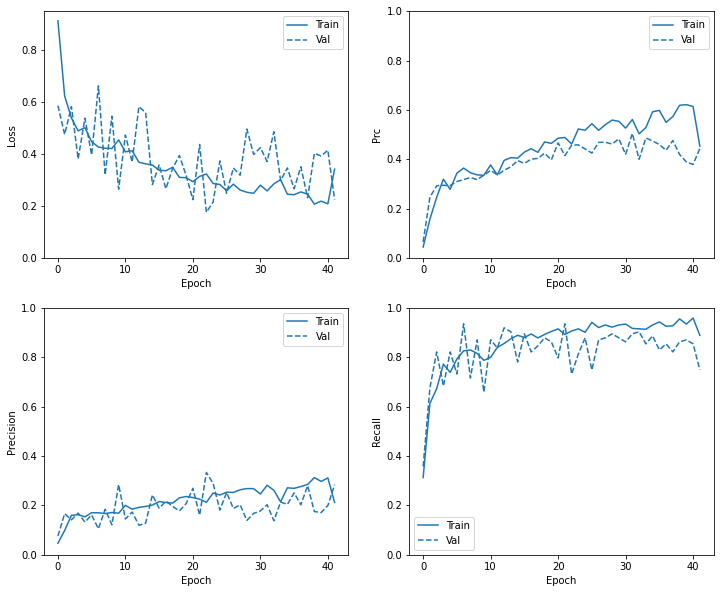

In [112]:
plot_metrics(weighted_history, colors)

In [113]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.4019399583339691
tp :  136.0
fp :  568.0
tn :  2838.0
fn :  34.0
accuracy :  0.8316555023193359
precision :  0.1931818127632141
recall :  0.800000011920929
auc :  0.8918085694313049
prc :  0.47150397300720215

True Job Postings Detected (True Negatives):  2838
True Job Postings Incorrectly Detected (False Positives):  568
False Job Postings Missed (False Negatives):  34
False Job Postings Detected (True Positives):  136
Total False Job Postings:  170


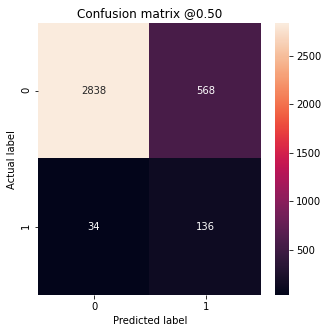

In [114]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

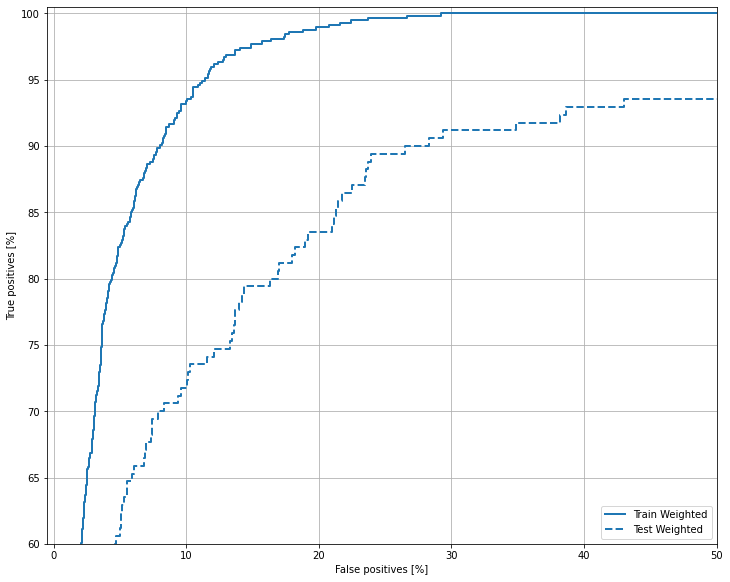

In [115]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

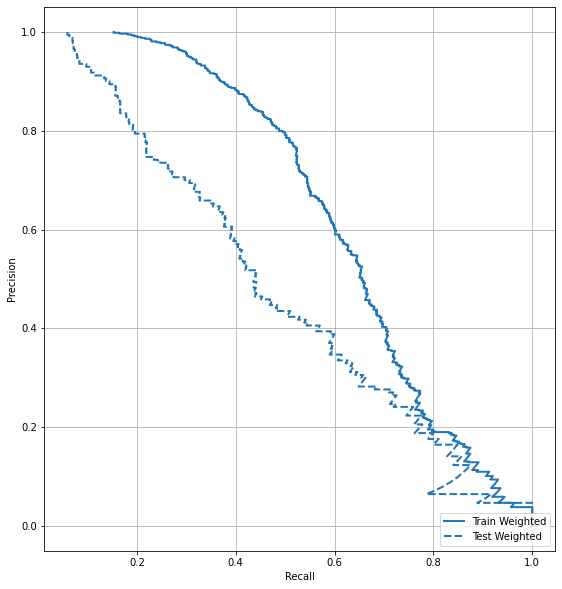

In [116]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [117]:
if MODEL in ['LSTM', 'BiLSTM']:
    keras.models.save_model(weighted_model, f'Model/LSTM/Classification/NN_{MODEL}')
else:
    keras.models.save_model(weighted_model, f'Model/Doc2Vec/Classification/NN_{MODEL}')

INFO:tensorflow:Assets written to: Model/Doc2Vec/Classification/NN_DBOW/assets
